# Processing time series

This notebook runs through some sanity checks about the photon flux calculations, comparing them to Bijan's spreadsheet results. This is to ensure that we properly process the input cubes, and gives an idea of how everything is done. Here we take the fiducial example of 47 Uma c.

In [2]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
#plt.rc('text', usetex=True)

import seaborn as sns
sns.set_style("whitegrid")
matplotlib.rcParams['axes.labelsize'] = 18
import sys
import os

folder = '../../../../crispy'
if folder not in sys.path: sys.path.append(folder)

from crispy.params import Params
folder = '../../../crispy'
par = Params(folder)



Populating the interactive namespace from numpy and matplotlib


## Calculate photon fluxes

### Calculate star rates

In [6]:
import glob

# load first filelist to get its shape
fileshape = (45,150,150)


import astropy.units as u
import astropy.constants as c
import astropy.analytic_functions as af

planet_radius = 1.27*c.R_jup
ref_star_T=9600#9377*u.K
ref_star_Vmag=2.37
target_star_T=5887*u.K
target_star_Vmag=5.03

lamc=660.
BW=0.18
R=50
n_ref_star_imgs=30
Nlam = 45
lamlist = lamc*np.linspace(1.-BW/2.,1.+BW/2.,Nlam)*u.nm
npixperdlam = 2
PSFLetWidth = 2

tel_pupil_area=np.pi*(2.37/2.*u.m)**2*0.835

from crispy.tools.inputScene import convert_krist_cube,calc_contrast_Bijan
target_star_cube = convert_krist_cube(fileshape,lamlist,target_star_T,target_star_Vmag,tel_pupil_area)
ref_star_cube = convert_krist_cube(fileshape,lamlist,ref_star_T,ref_star_Vmag,tel_pupil_area)
print("Telescope area: {:.4E}".format(tel_pupil_area))
print("Photons from the target star over entire band: Us: %.3e; Bijan: %.3e" % (np.mean(target_star_cube[:,0,0]/45*0.18*lamc),1.14e8*tel_pupil_area.value))
print("Photons from the reference star over entire band: Us: %.3e; Bijan: %.3e" % (np.mean(ref_star_cube[:,0,0]/45*0.18*lamc),1.07e9*tel_pupil_area.value))
print("Planet contrast at maximum of the spectrum: {:.4E}".format(np.amax(calc_contrast_Bijan(lamlist))))
print("Planet flux within band: Us: {:.4E}".format(np.sum(target_star_cube[:,0,0]/45*0.18*lamc/45.*calc_contrast_Bijan(lamlist)))+"; Bijan: {:.4E}".format(0.79*tel_pupil_area.value))
print('This makes sense since we use a real spectrum, that contains absorption lines and such')
print("Planet flux within single spectral channel (lossless case): {:.4f}".format(np.sum(target_star_cube[:,0,0]/45*0.18*lamc/45.*calc_contrast_Bijan(lamlist))/(npixperdlam*BW*R))+" assuming %d spectral channels"% (npixperdlam*BW*R))
print("Planet flux within single pixel (lossless case): {:.4f}".format(np.sum(target_star_cube[:,0,0]/45*0.18*lamc/45.*calc_contrast_Bijan(lamlist))/(npixperdlam*BW*R*PSFLetWidth))+" assuming %d pixels per spectral channel"% (PSFLetWidth))


Telescope area: 3.6836E+00 m2
Photons from the target star over entire band: Us: 4.710e+08; Bijan: 4.199e+08
Photons from the reference star over entire band: Us: 4.245e+09; Bijan: 3.941e+09
Planet contrast at maximum of the spectrum: 7.9584E-09
Planet flux within band: Us: 3.5690E+00; Bijan: 2.9100E+00
This makes sense since we use a real spectrum, that contains absorption lines and such
Planet flux within single spectral channel (lossless case): 0.1983 assuming 18 spectral channels
Planet flux within single pixel (lossless case): 0.0991 assuming 2 pixels per spectral channel


In [5]:
from astropy.io import fits
offaxis=fits.getdata('/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits')
print np.sum(offaxis)

0.146599718889


### Test zodi calculations

In [3]:
from crispy.tools.inputScene import zodi_cube
local_zodi_mag = 23
exozodi_mag = 22
D = 2.37
pixarea = (0.1*770*1e-9/D/4.848e-6)**2
dist=14.1
absmag = target_star_Vmag-5*np.log10(dist/10.)

zodicube = zodi_cube(target_star_cube,
                     area_per_pixel=pixarea,
                     absmag=absmag,
                     Vstarmag = target_star_Vmag,
                     zodi_surfmag=local_zodi_mag,
                     exozodi_surfmag=exozodi_mag,
                     distAU=3.6,t_zodi=0.09)
print "Total ph/sec/as2/m2",np.mean(np.sum(np.sum(zodicube,axis=2),axis=1),axis=0)*0.18*lamc/tel_pupil_area
print "Total ph/sec/pix/m2",np.mean(np.sum(np.sum(zodicube,axis=2),axis=1),axis=0)*0.18*lamc/tel_pupil_area/150**2
print "Total ph/sec/lenslets/m2",np.mean(np.sum(np.sum(zodicube,axis=2),axis=1),axis=0)*0.18*lamc/tel_pupil_area/150**2*25
print "Total ph/sec/lenslet",np.mean(np.sum(np.sum(zodicube,axis=2),axis=1),axis=0)*0.18*lamc/150**2*25
print "Total ph/sec/lenslet/nm",np.mean(np.sum(np.sum(zodicube,axis=2),axis=1),axis=0)/150**2*25
print "Total ph/sec/lenslet/channel",np.mean(np.sum(np.sum(zodicube,axis=2),axis=1),axis=0)*0.18*lamc/150**2*25/9
print "Total ph/fr/lenslet/channel",np.mean(np.sum(np.sum(zodicube,axis=2),axis=1),axis=0)*0.18*lamc/150**2*25*100/9
print "Total ph/fr/ifspix/channel",np.mean(np.sum(np.sum(zodicube,axis=2),axis=1),axis=0)*0.18*lamc/150**2*25*100/9/4


Total ph/sec/as2/m2 0.996076061813 1 / m2
Total ph/sec/pix/m2 4.42700471917e-05 1 / m2
Total ph/sec/lenslets/m2 0.00110675117979 1 / m2
Total ph/sec/lenslet 0.00407683413341
Total ph/sec/lenslet/nm 3.43167856347e-05
Total ph/sec/lenslet/channel 0.000452981570379
Total ph/fr/lenslet/channel 0.0452981570379
Total ph/fr/ifspix/channel 0.0113245392595


# Check photometry at detector

In [4]:
import astropy.units as u


In [5]:
from crispy.tools.postprocessing import process_planet
tel_pupil_area=np.pi*(2.37/2.*u.m)**2*0.835
offaxis_psf_filename='/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
from astropy.io import fits
par.savePoly=True
detector = process_planet(par,offaxis_psf_filename=offaxis_psf_filename,
                fileshape=fits.open(offaxis_psf_filename)[0].data.shape,
                lamlist=lamlist,
                lamc=lamc,
                outdir_average=par.exportDir,
                planet_radius = 1.27*c.R_jup,
                planet_AU = 3.6,planet_dist_pc=14.1,
                target_star_T=5887*u.K, target_star_Vmag=5.03,
                tel_pupil_area=3.650265060424805*u.m**2)


ImportError: cannot import name process_planet

In [ ]:
from crispy.tools.image import Image
from crispy.tools.detector import readDetector
from crispy.IFS import reduceIFSMap
par.nonoise=True
det = readDetector(par,Image(par.exportDir+'/offaxis_planet.fits'),inttime=1)
outkey = fits.HDUList(fits.PrimaryHDU(det))
outkey.writeto(par.exportDir+'/detector_offaxis.fits',clobber=True)
reduceIFSMap(par,par.exportDir+'/detector_offaxis.fits')

In [ ]:
print("Sum of of flux before detector w/o losses (ph-electrons per second):",np.sum(detector))
print("Sum of detector flux w/ losses (electrons per second):",np.sum(det))
print("Sum of flux at lenslet array (ph per second):",np.nansum(Image(par.exportDir+'/detector_offaxis_red_optext.fits').data))

flux_cube = np.sum(target_star_cube[:,0,0]/45*0.18*lamc/45.*calc_contrast_Bijan(lamlist))
print("Flux in input cube:",flux_cube)
print("Throughput of offaxis PSF:",np.sum(fits.open(offaxis_psf_filename)[0].data))
print("Throughput of shifted offaxis PSF:",np.nansum(fits.open(par.exportDir+'/offaxiscube_shifted.fits')[1].data))
from scipy.interpolate import interp1d
loadQE = np.loadtxt(par.codeRoot+"/"+par.QE)
QEinterp = interp1d(loadQE[:,0],loadQE[:,1])
QEvals = QEinterp(lamlist)
print("QE:",np.mean(QEvals))
print("Total estimated number of counts:",flux_cube*np.sum(fits.open(offaxis_psf_filename)[0].data)*np.mean(QEvals))
print("Total estimated number of counts #2:",np.sum(target_star_cube[:,0,0]/45*0.18*lamc*calc_contrast_Bijan(lamlist)*np.sum(np.sum(fits.open(offaxis_psf_filename)[0].data,axis=2),axis=1)*QEvals))

In [ ]:
from crispy.tools.image import Image
poly = Image(par.exportDir+'/detectorFramepoly.fits')
numslice = 25
print(np.sum(poly.data[numslice]))
print(target_star_cube[numslice,0,0]/45*0.18*lamc*calc_contrast_Bijan(lamlist)[numslice]*np.sum(fits.open(offaxis_psf_filename)[0].data[numslice])*QEvals[numslice])
print("Percentage error in slice:",(np.sum(poly.data[numslice])-target_star_cube[numslice,0,0]/45*0.18*lamc*calc_contrast_Bijan(lamlist)[numslice]*np.sum(fits.open(offaxis_psf_filename)[0].data[numslice])*QEvals[numslice])/(np.sum(poly.data[numslice])))


In [ ]:
print np.mean(target_star_cube[:,0,0]/45*0.18*770*10**(0.4*target_star_Vmag))/tel_pupil_area
print(1/np.sqrt(pixarea))
print(np.sum(np.sum(zodicube,axis=2),axis=1))
print np.mean(target_star_cube[:,0,0]/45*0.18*770*10**(0.4*target_star_Vmag-0.4*(local_zodi_mag)))/tel_pupil_area

# Test reduction with flatfield

In [ ]:
from crispy.unitTests import testCreateFlatfield
from crispy.tools.image import Image
offaxis_psf_filename='/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
from crispy.tools.reduction import calculateWaveList
shape = Image(offaxis_psf_filename).data.shape
lam_midpts,lam_endpts = calculateWaveList(par,Nspec=shape[0],method='optext')
print lam_midpts
dlam = lam_endpts[1]-lam_endpts[0]
print dlam
par.savePoly=True
par.saveRotatedInput=True
testCreateFlatfield(par,pixsize=0.1,npix = shape[1],Nspec=shape[0],pixval = 1./dlam,useQE=True)

In [ ]:
from crispy.IFS import reduceIFSMap
reduceIFSMap(par,par.unitTestsOutputs+'/flatfield.fits')


In [ ]:
print(np.nansum(Image(par.unitTestsOutputs+'/flatfield.fits').data))
print(np.nansum(Image(par.exportDir+'/flatfield_red_optext.fits').data))


# Star photometry

In [6]:
from crispy.tools.postprocessing import processReferenceCubes,processTargetCubes
filename = '/Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_031.fits'
# processReferenceCubes(par,xshift=0.0,yshift=0.0,order=3,
#                 outdir_time_series = par.exportDir,
#                 ref_input_list=[filename],
#                 process_cubes=True,
#                 ref_star_T=9377*u.K, ref_star_Vmag=2.37,
#                 lamc=660.,BW = 0.18,
#                 tel_pupil_area=3.650265060424805*u.m**2)
processTargetCubes(par,[filename],
                outdir_time_series = par.exportDir,
                process_cubes=True,
                target_star_T=5887*u.K, target_star_Vmag=5.03,
                lamc=660.,BW = 0.18,
                tel_pupil_area=3.650265060424805*u.m**2,
                )


crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_031.fits
crispy - INFO - Processing file os5_spc_031.fits
crispy - INFO - The number of input pixels per lenslet is 5.000000
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Done.
crispy - INFO - Performance: 37 seconds total
crispy - INFO - Writing data to ../../../crispy/SimResults/os5_spc_031_targetstar_IFS.fits


['../../../crispy/SimResults/os5_spc_031_targetstar_IFS.fits']

In [8]:
from astropy.io import fits
from crispy.tools.image import Image
from crispy.tools.detector import readDetector
from crispy.IFS import reduceIFSMap
par.nonoise=True
det = readDetector(par,Image(par.exportDir+'/os5_spc_031_targetstar_IFS.fits'),inttime=1)
outkey = fits.HDUList(fits.PrimaryHDU(det))
outkey.writeto(par.exportDir+'/os5_spc_031_targetstar_IFS_detector.fits',clobber=True)
reduceIFSMap(par,par.exportDir+'/os5_spc_031_targetstar_IFS_detector.fits')

crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/os5_spc_031_targetstar_IFS.fits
crispy - INFO - Read data from HDU 0 of ../../../crispy/SimResults/os5_spc_031_targetstar_IFS_detector.fits
crispy - INFO - Reduced cube will have 19 wavelength bins
crispy - INFO - Writing data to ../../../crispy/SimResults/os5_spc_031_targetstar_IFS_detector_red_optext.fits
crispy - INFO - Elapsed time: 1.520822s


<crispy.tools.image.Image instance at 0x10eb23488>

## Calibration cube

The goal of this is to construct a cube that normalizes the extracted spectrum from counts per second per nm to input photons per second per nm.

In [9]:
import astropy.units as u
import astropy.constants as c
from crispy.tools.image import Image
from astropy.io import fits

<function __main__.plt_cubes_slices>

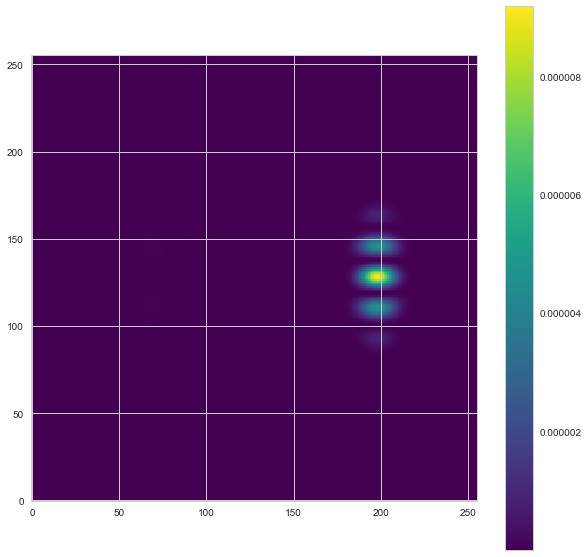

In [10]:
from crispy.tools.postprocessing import processReferenceCubes,processTargetCubes
offaxis_psf_filename='/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
offaxis_psf = Image(offaxis_psf_filename)
lamc=660.
BW = 0.18
import ipywidgets
def plt_cubes_slices(wchan):
    plt.figure(figsize=(10,10))
    plt.imshow(offaxis_psf.data[wchan-1], cmap='viridis')
    plt.colorbar()
ipywidgets.interact(plt_cubes_slices, wchan=(1,offaxis_psf.data.shape[0]))

Sum of photon flux within offaxis cube: 0.146600


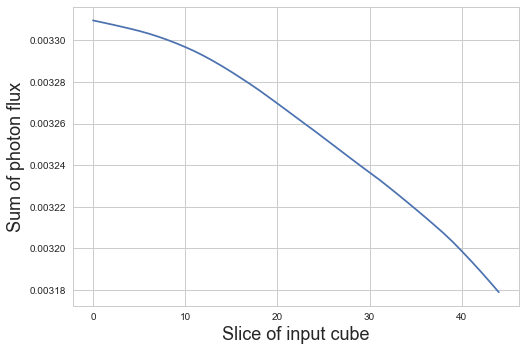

In [11]:
print("Sum of photon flux within offaxis cube: %f" % np.sum(offaxis_psf.data))
plt.plot(np.sum(np.sum(offaxis_psf.data,axis=2),axis=1))
plt.xlabel("Slice of input cube")
plt.ylabel("Sum of photon flux")

### Process planet PSF

In [13]:
from crispy.tools.postprocessing import process_offaxis

reference_file = '/Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_001.fits'
fileshape = Image(reference_file).data.shape
lamlist = lamc*np.linspace(1.-BW/2.,1.+BW/2.,fileshape[0])*u.nm
par.savePoly =True
# process_planet(par,offaxis_psf_filename,fileshape=fileshape,
#             lamlist=lamlist,
#             lamc=lamc,
#             outdir_average=par.exportDir,
#             planet_radius = 1.27*c.R_jup,
#             planet_AU = 3.6,planet_dist_pc=14.1,
#             target_star_T=5887*u.K, target_star_Vmag=5.03,
#             tel_pupil_area=3.650265060424805*u.m**2, order=3)
par.timeframe=1
par.Nreads=1
process_offaxis(par,offaxis_psf_filename,fileshape,lamlist,lamc,outdir_average=par.exportDir,Nave=1)


crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/with_lowfc/os5_spc_001.fits
crispy - INFO - Recentering off-axis cube
crispy - INFO - Read data from HDU 0 of /Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits
crispy - INFO - The number of input pixels per lenslet is 5.000000
crispy - INFO - Writing data to ../../../crispy/SimResults/offaxiscube.fits
crispy - INFO - Constructing off-axis cube at planet separation: 4.44 lam/D (0.26 arcsec, 8.89 lenslets)
crispy - INFO - Writing data to ../../../crispy/SimResults/offaxiscube_shifted.fits
crispy - INFO - Writing data to ../../../crispy/SimResults/offaxiscube_star_processed.fits
crispy - INFO - The number of input pixels per lenslet is 5.000000
crispy - INFO - Using PSFlet gaussian approximation
crispy - WARNING - Assuming slices are evenly spread in wavelengths
crispy - INFO - Writing data to ../../../crispy/SimResults/detectorFramepoly.fits
crispy - INFO - Done.
crispy - INFO - Performance: 37 seconds total
crispy - INFO - W

<crispy.tools.image.Image instance at 0x11a427758>

### Evaluate photometry

crispy - INFO - Reduced cube will have 19 wavelength bins
dlam in reduced cube: 6.315789
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/offaxiscube_star_processed.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/offaxis_star.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/offaxis_detector.fits
crispy - INFO - Read data from HDU 1 of ../../../crispy/SimResults/offaxis_star_detector_red_optext.fits
crispy - INFO - Read inverse variance from HDU 2 of ../../../crispy/SimResults/offaxis_star_detector_red_optext.fits
Sum of all photon rates per nm in input cube: 25922284.000000
Sum of all photon rates before the detector (without optical losses but including QE): 60147772.000000
Sum of all photon rates at the detector: 20451172.000000
Sum of all cube counts in the reduced cube: 20506436.000000


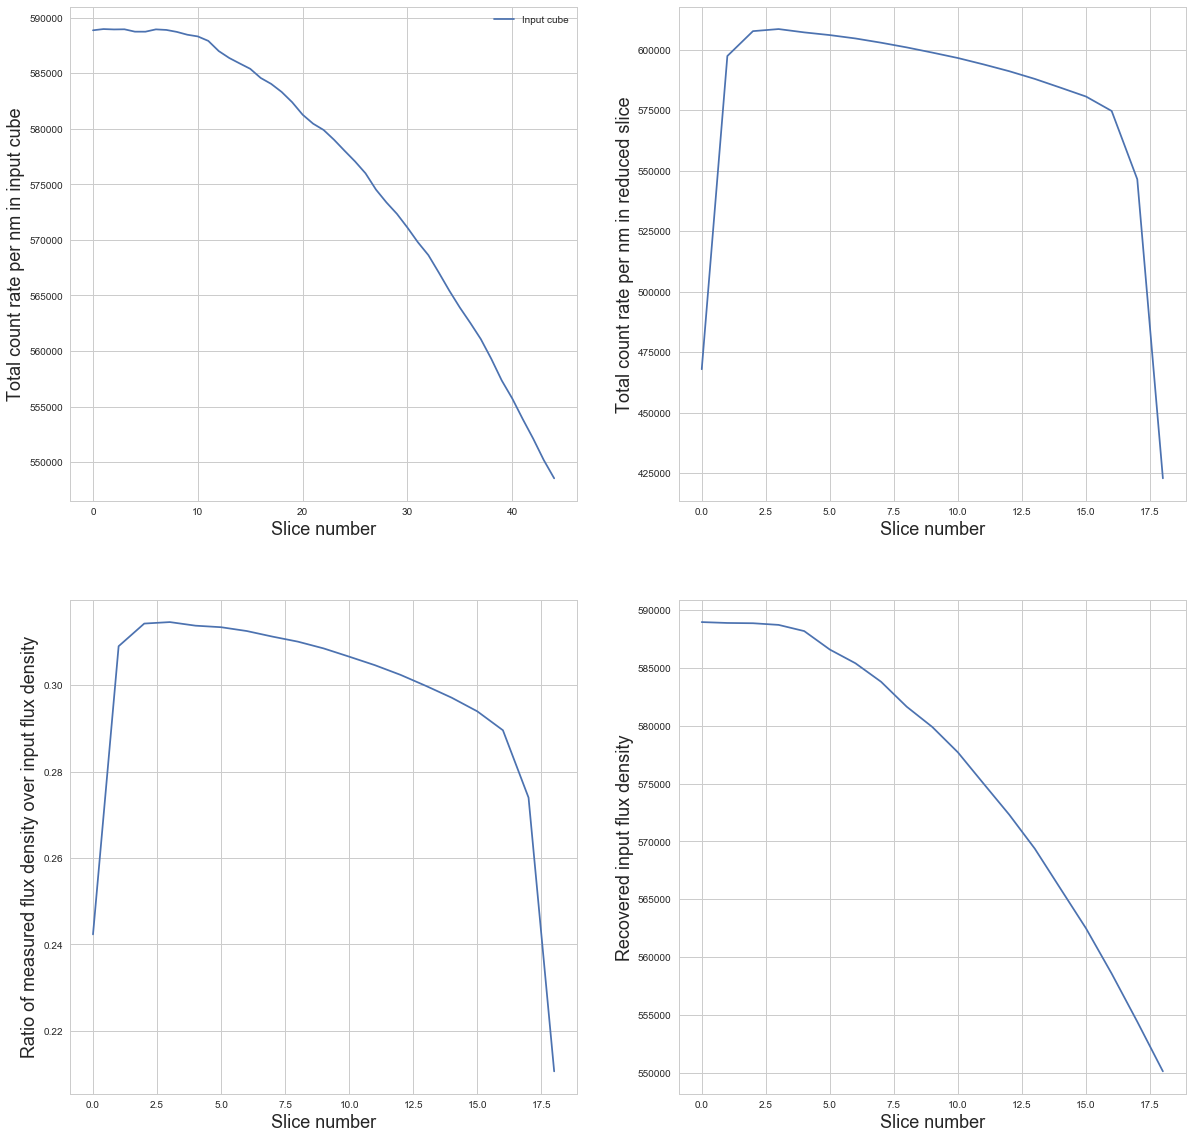

In [24]:
from crispy.tools.reduction import calculateWaveList
lam_midpts,waveList = calculateWaveList(par,method='optext')
dlam = (waveList[-1]-waveList[0])/(len(waveList)-1)
print("dlam in reduced cube: %f" % dlam)
from scipy.interpolate import interp1d

loadQE = np.loadtxt(par.codeRoot+"/"+par.QE)
QE = interp1d(loadQE[:,0],loadQE[:,1])

offaxiscube_star_processed = Image(par.exportDir+"/offaxiscube_star_processed.fits")
offaxis_star = Image(par.exportDir+"/offaxis_star.fits")
offaxis_detector = Image(par.exportDir+"/offaxis_detector.fits")
offaxis_detector_cube = Image(par.exportDir+"/offaxis_star_detector_red_optext.fits")
print("Sum of all photon rates per nm in input cube: %f" % np.nansum(offaxiscube_star_processed.data))
print("Sum of all photon rates before the detector (without optical losses but including QE): %f" % np.nansum(offaxis_star.data))
print("Sum of all photon rates at the detector: %f" % np.nansum(offaxis_detector.data))
print("Sum of all cube counts in the reduced cube: %f" % np.nansum(offaxis_detector_cube.data))


input_flux_density = interp1d(lamlist,np.nansum(np.nansum(offaxiscube_star_processed.data,axis=2),axis=1))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.plot(np.nansum(np.nansum(offaxiscube_star_processed.data,axis=2),axis=1))
#plt.plot(np.nansum(np.nansum(offaxis_detector_poly.data/QE(lamlist)[:,np.newaxis,np.newaxis]/(dlam*len(lam_midpts)/len(lamlist)),axis=2),axis=1))
plt.legend(["Input cube"])
plt.xlabel("Slice number")
plt.ylabel("Total count rate per nm in input cube")
plt.subplot(222)
plt.plot(np.nansum(np.nansum(offaxis_detector_cube.data/dlam/par.losses/QE(lam_midpts)[:,np.newaxis,np.newaxis],axis=2),axis=1))
plt.xlabel("Slice number")
plt.ylabel("Total count rate per nm in reduced slice")
plt.subplot(223)
ratio = np.nansum(np.nansum(offaxis_detector_cube.data,axis=2),axis=1)/input_flux_density(lam_midpts)/dlam
plt.plot(ratio)
plt.xlabel("Slice number")
plt.ylabel("Ratio of measured flux density over input flux density")
plt.subplot(224)
plt.plot(np.nansum(np.nansum(offaxis_detector_cube.data/dlam/ratio[:,np.newaxis,np.newaxis],axis=2),axis=1))
plt.xlabel("Slice number")
plt.ylabel("Recovered input flux density")




### Plots

In [ ]:
trim = 30
def plt_cubes_slices(wchan):
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.imshow(offaxis_planet_cube.data[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.colorbar()
    plt.subplot(122)
    plt.imshow(offaxis_flipped_planet_cube.data[wchan-1,trim:-trim,trim:-trim], cmap='viridis')
    plt.colorbar()
ipywidgets.interact(plt_cubes_slices, wchan=(1,offaxis_planet_cube.data.shape[0]));

# All below is obsolete

# inputCube = np.ones((1,512,512),dtype=float)
inCube = pyf.HDUList(pyf.PrimaryHDU(inputCube))
inCube[0].header['LAM_C'] = 770./1000.
inCube[0].header['PIXSIZE'] = 0.1
dlam=1.
par.saveRotatedInput=True

detectorFrame = polychromeIFS(par,[770.],inCube[0],dlambda=dlam,parallel=False)
filename = par.exportDir+'/det_660.fits'
Image(data=detectorFrame,header=par.hdr).write(filename)
